#### Looking for Non-seasonal trends and Stationarity

In [13]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss

/Users/snehsuresh/anaconda3/envs/myenv3.9/lib/python3.9/site-packages/scipy/special/__init__.py:777: RuntimeWarning: coroutine 'fetch_and_write_categories' was never awaited
  from . import _ufuncs


In [14]:
file_path = "data/alpha_vantage/retail_sales.json"

with open(file_path, "r") as f:
    data = json.load(f)

In [15]:
df = pd.DataFrame(data["data"])
df["date"] = pd.to_datetime(df["date"])
df["value"] = pd.to_numeric(df["value"])
df.set_index("date", inplace=True)
df = df.sort_index()

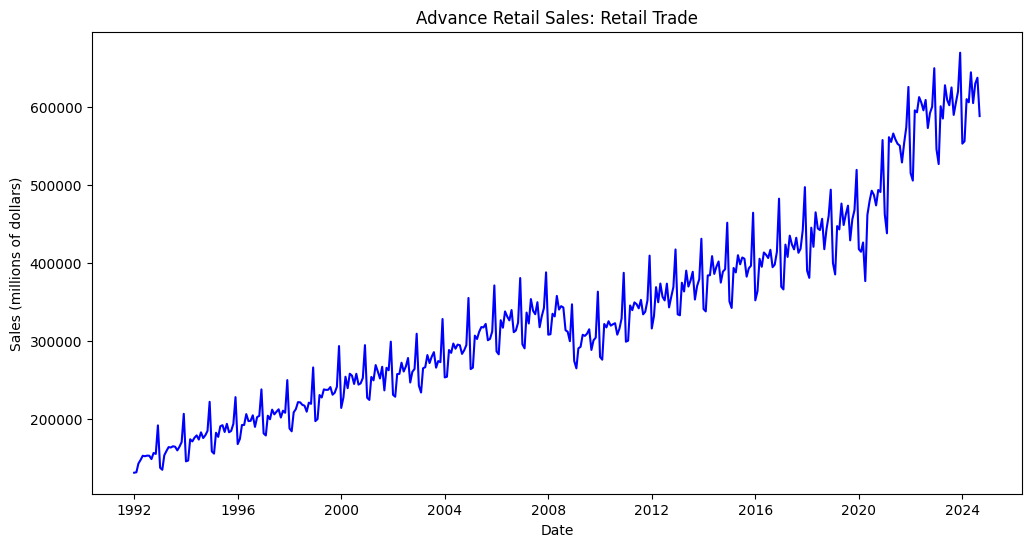

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df["value"], color="blue")
plt.title("Advance Retail Sales: Retail Trade")
plt.xlabel("Date")
plt.ylabel("Sales (millions of dollars)")
plt.show()

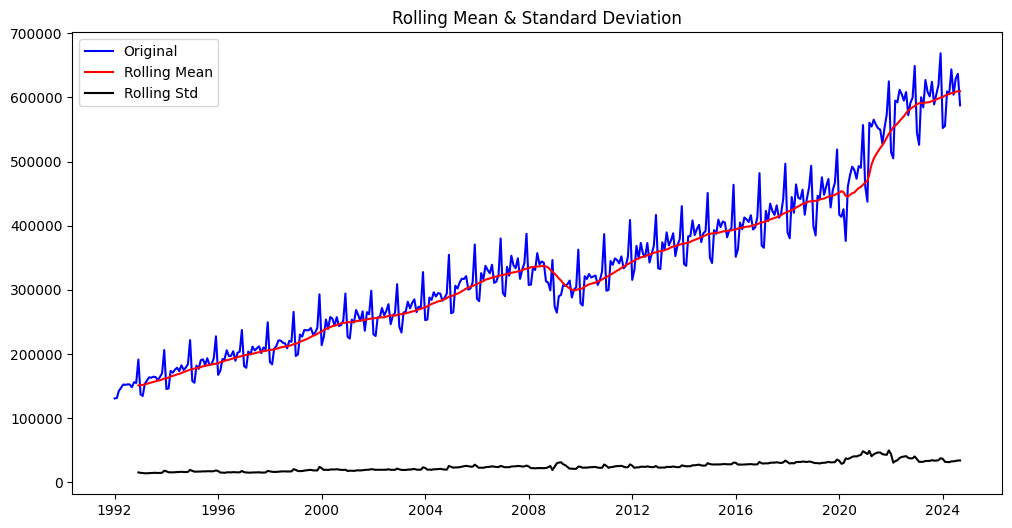

In [17]:

rolling_window = 12  # Monthly data, so a 12-month rolling window
df["Rolling Mean"] = df["value"].rolling(window=rolling_window).mean()
df["Rolling Std"] = df["value"].rolling(window=rolling_window).std()

plt.figure(figsize=(12, 6))
plt.plot(df["value"], color="blue", label="Original")
plt.plot(df["Rolling Mean"], color="red", label="Rolling Mean")
plt.plot(df["Rolling Std"], color="black", label="Rolling Std")
plt.title("Rolling Mean & Standard Deviation")
plt.legend()
plt.show()

#### Removing trends

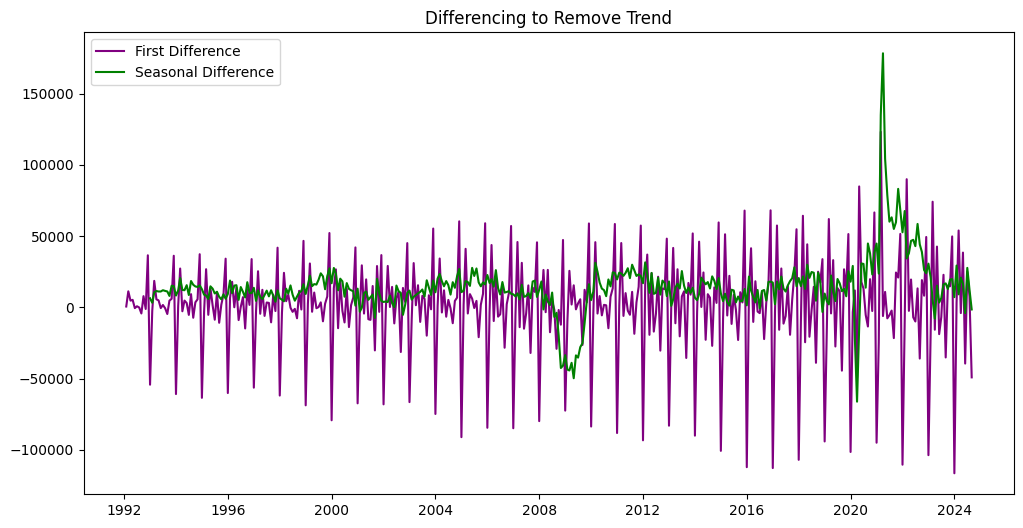

In [21]:
df["First Difference"] = df["value"].diff()
df["Seasonal Difference"] = df["value"].diff(
    rolling_window
)  # Seasonal differencing for 12-month seasonality

plt.figure(figsize=(12, 6))
plt.plot(df["First Difference"], color="purple", label="First Difference")
plt.plot(df["Seasonal Difference"], color="green", label="Seasonal Difference")
plt.title("Differencing to Remove Trend")
plt.legend()
plt.show()

#### Checking for stationarity

In [22]:
# Stationarity Tests
# Augmented Dickey-Fuller Test
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Test:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value}")
    if result[1] < 0.05:
        print("Conclusion: Reject the null hypothesis. Data is stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis. Data is non-stationary.")


# KPSS Test
def kpss_test(series):
    result = kpss(series.dropna(), regression="c")
    print("\nKPSS Test:")
    print(f"KPSS Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    for key, value in result[3].items():
        print(f"Critical Value {key}: {value}")
    if result[1] < 0.05:
        print("Conclusion: Reject the null hypothesis. Data is non-stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis. Data is stationary.")


print("\n--- ADF Test on Original Data ---")
adf_test(df["value"])
print("\n--- KPSS Test on Original Data ---")
kpss_test(df["value"])

print("\n--- ADF Test on First Differenced Data ---")
adf_test(df["First Difference"])
print("\n--- KPSS Test on First Differenced Data ---")
kpss_test(df["First Difference"])

print("\n--- ADF Test on Seasonally Differenced Data ---")
adf_test(df["Seasonal Difference"])
print("\n--- KPSS Test on Seasonally Differenced Data ---")
kpss_test(df["Seasonal Difference"])


--- ADF Test on Original Data ---
ADF Test:
ADF Statistic: 0.82418733669271
p-value: 0.9920167330188467
Critical Value 1%: -3.4478619826418817
Critical Value 5%: -2.869257669826291
Critical Value 10%: -2.570881358363513
Conclusion: Fail to reject the null hypothesis. Data is non-stationary.

--- KPSS Test on Original Data ---

KPSS Test:
KPSS Statistic: 3.11570025862761
p-value: 0.01
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
Conclusion: Reject the null hypothesis. Data is non-stationary.

--- ADF Test on First Differenced Data ---
ADF Test:
ADF Statistic: -3.992559980428671
p-value: 0.0014499743678375852
Critical Value 1%: -3.4478619826418817
Critical Value 5%: -2.869257669826291
Critical Value 10%: -2.570881358363513
Conclusion: Reject the null hypothesis. Data is stationary.

--- KPSS Test on First Differenced Data ---

KPSS Test:
KPSS Statistic: 0.14294482764419733
p-value: 0.1
Critical Value 10%: 0.347
Critical Value 5%:

/var/folders/vv/27_476013ls6_cwg052s2mt40000gn/T/ipykernel_67982/328047054.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression="c")
/var/folders/vv/27_476013ls6_cwg052s2mt40000gn/T/ipykernel_67982/328047054.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression="c")


#### Looking for autocorrelation between data

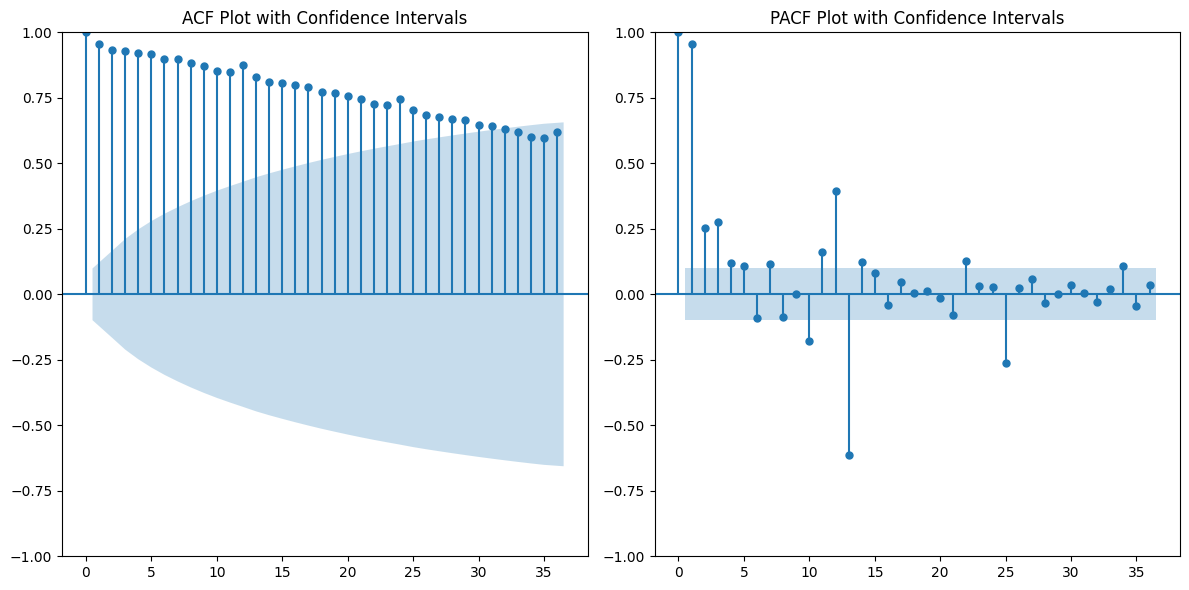

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(df['value'], lags=36, ax=plt.gca(), alpha=0.05)  # Confidence interval at 95%
plt.title("ACF Plot with Confidence Intervals")

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(df['value'], lags=36, ax=plt.gca(), alpha=0.05)  # Confidence interval at 95%
plt.title("PACF Plot with Confidence Intervals")

plt.tight_layout()
plt.show()

1. ACF
- We can see a gradual(long memory) autocorrelation decay (remains significant over many lags), it implies that past observations continue to have an influence on current values for an extended period. This indicates the potential for longer-term dependencies within the data. The spikes are outside the confidence interval until lag 30.
- A slow decay (significant at many lags) suggests the need for higher-order AR terms or even combinations of AR and MA terms in the model.

2. PACF
- The PACF dropping sharply after a couple of lags (e.g., Lag 1 and Lag 2) suggests that there are significant direct relationships with the immediate past values (the last one or two observations).
- Implication: This behavior indicates that your time series may only require autoregressive (AR) terms up to Lag 2. In practical terms, it suggests an AR model of order 2 (AR(2)) could be sufficient.

#### Ideally we should go with ARIMA(1,0,0) now that we have already differenced the data. But to be safe, let's do a pairwise search to get the best fit.

In [4]:
from pmdarima import auto_arima

model = auto_arima(
    df["value"],
    seasonal=False,  
    stepwise=True,
    suppress_warnings=True,
    trace=True,
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=66.885, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=36.244, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=37.189, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.190 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   10
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -16.122
Date:                Sat, 26 Oct 2024   AIC                             36.244
Time:                        16:36:05   BIC                        


- The stepwise search for the best ARIMA model revealed that ARIMA(1,0,0) was optimal, as indicated by the lowest AIC value of 36.244. This model structure, characterized by one autoregressive term and no differencing or moving average components, suggests a reliance on the most recent observation to predict future values. While the simplicity of ARIMA(1,0,0) makes it easy to interpret, it may not capture more complex behaviors inherent in the economic data, such as trends or seasonality.

- To enhance the analysis, I also considered the SARIMAX(1,0,0) model. This model retains the autoregressive component but offers the flexibility to incorporate seasonal effects and exogenous variables, making it particularly valuable in economic forecasting. The ability to account for external factors—such as policy changes or market conditions—can lead to more accurate forecasts, especially in the face of a dynamic economic environment.

- The results from the SARIMAX model provided a comprehensive view of the relationships within the data, highlighting how past values of the economic indicator influence future outcomes. Additionally, the residual diagnostics indicated some non-normality in the errors, suggesting areas for further model refinement.

- Ultimately, both models serve as important tools in my forecasting toolkit, with ARIMA(1,0,0) offering a straightforward approach, while SARIMAX(1,0,0) allows for a more nuanced understanding of the data by accommodating external influences. This analysis underscores the importance of model selection in capturing the intricacies of economic indicators and the need for continuous evaluation as new data becomes available.

## Practical Considerations in Economic Forecasting

#### We found ARIMA (1,0,0) to be the best fit

1. Monthly Growth Dynamics:
The autoregressive term indicates that the current month's retail sales are largely influenced by the sales from the previous month. This means that if retail sales increase or decrease in one month, it will likely influence the direction of sales in the following month. For instance, if sales were robust last month, you might expect similar trends to continue, reflecting consumer behavior and economic conditions. This might suggest that consumers react to recent purchasing behaviors. For example, if there was an uptick in sales due to seasonal promotions, the trend may carry into the following month, indicating a momentum effect in consumer spending.


2. The fact that I needed to difference the data once implies that the raw sales data exhibited a trend over time, likely due to seasonal effects, changing consumer preferences, inflation, or economic cycles. This means that while the level of retail sales might show a long-term growth trend (possibly influenced by inflation or economic expansion), the model is analyzing the changes in sales values month-over-month. In this context, a differenced model allows you to focus on whether retail sales are increasing or decreasing relative to the previous month, thus providing insights into economic health and consumer confidence.

3. Absence of Moving Average Component (q=0): With no moving average component, the model doesn’t account for past forecast errors, suggesting that the changes in retail sales are primarily driven by the recent trend rather than any random shocks or irregularities from prior periods. This reflects a straightforward relationship where the most recent month’s change serves as a reliable predictor for the next month. It implies that while there might be fluctuations due to various factors (like economic policy changes or seasonal effects), those fluctuations are not complexly influenced by past discrepancies in forecasts.
